# IMPORTS

In [1]:
# Parameters 

provider = 'CDS'
GCM = 'DWD'
stage_in = "processed"
period = "hindcasts"
var_name = "T2M"

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt 
import proplot as plot

In [3]:
import os
import sys 
import pathlib

In [4]:
import numpy as np 
import pandas as pd 

In [5]:
import xarray as xr

### ML 

In [6]:
import sklearn
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler

In [7]:
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

In [8]:
if not tf.test.is_gpu_available():
    print("No GPU was detected")

### random seeds for reproducibility 

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

### data loading 

In [10]:
HOME = pathlib.Path.home()

In [11]:
local = True 

In [12]:
if local: 
    dirin = pathlib.Path('research/Smart_Ideas')
else: 
    dirin = pathlib.Path('drives/auck_projects/END19101/Working')

In [13]:
ipath = HOME / dirin / 'data' / 'GCMs' / stage_in / period / provider / GCM / var_name

In [14]:
ipath

PosixPath('/home/nicolasf/research/Smart_Ideas/data/GCMs/processed/hindcasts/CDS/DWD/T2M')

### loading the forecasts 

In [15]:
lfiles_nc = list(ipath.glob(f"{GCM}_{var_name}_seasonal_anomalies_interp_????_??.nc"))

In [16]:
len(lfiles_nc)

288

In [17]:
lfiles_nc.sort()

### opens the dataset 

In [18]:
dset = xr.open_mfdataset(lfiles_nc, combine='nested', concat_dim='time')

In [19]:
dset

<xarray.Dataset>
Dimensions:     (lat: 73, lon: 144, member: 30, step: 3, time: 288)
Coordinates:
    surface     int64 0
  * step        (step) int64 3 4 5
  * member      (member) int64 0 1 2 3 4 5 6 7 8 ... 21 22 23 24 25 26 27 28 29
  * lon         (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat         (lat) float64 -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
  * time        (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
    month       (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
    valid_time  (time, step) datetime64[ns] dask.array<chunksize=(1, 3), meta=np.ndarray>
Data variables:
    t2m         (time, member, step, lat, lon) float64 dask.array<chunksize=(1, 30, 3, 73, 144), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

### only select step 3, and restrict geographical coverage 

In [20]:
dset = dset.sel(step=3, lat=slice(-65, 65), lon=slice(90, 220))

In [21]:
nx, ny = len(dset.lon), len(dset.lat)

In [22]:
nx, ny

(53, 53)

### calculates the ensemble mean 

In [23]:
dset = dset.mean('member')

In [24]:
dset

<xarray.Dataset>
Dimensions:     (lat: 53, lon: 53, time: 288)
Coordinates:
    surface     int64 0
    step        int64 3
  * lon         (lon) float64 90.0 92.5 95.0 97.5 ... 212.5 215.0 217.5 220.0
  * lat         (lat) float64 -65.0 -62.5 -60.0 -57.5 ... 57.5 60.0 62.5 65.0
  * time        (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
    month       (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
    valid_time  (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    t2m         (time, lat, lon) float64 dask.array<chunksize=(1, 53, 53), meta=np.ndarray>

### load in memory 

In [25]:
dset.compute()

<xarray.Dataset>
Dimensions:     (lat: 53, lon: 53, time: 288)
Coordinates:
    surface     int64 0
    step        int64 3
  * lon         (lon) float64 90.0 92.5 95.0 97.5 ... 212.5 215.0 217.5 220.0
  * lat         (lat) float64 -65.0 -62.5 -60.0 -57.5 ... 57.5 60.0 62.5 65.0
  * time        (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
    month       (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
    valid_time  (time) datetime64[ns] 1993-05-01 1993-06-01 ... 2017-04-01
Data variables:
    t2m         (time, lat, lon) float64 0.1702 0.2047 0.2736 ... 0.7505 0.818

In [26]:
dset.load()

<xarray.Dataset>
Dimensions:     (lat: 53, lon: 53, time: 288)
Coordinates:
    surface     int64 0
    step        int64 3
  * lon         (lon) float64 90.0 92.5 95.0 97.5 ... 212.5 215.0 217.5 220.0
  * lat         (lat) float64 -65.0 -62.5 -60.0 -57.5 ... 57.5 60.0 62.5 65.0
  * time        (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
    month       (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
    valid_time  (time) datetime64[ns] 1993-05-01 1993-06-01 ... 2017-04-01
Data variables:
    t2m         (time, lat, lon) float64 0.1702 0.2047 0.2736 ... 0.7505 0.818

In [27]:
dset_train = dset.sel(time=slice(None, '2010'))

In [28]:
dset_valid = dset.sel(time=slice('2011', None))

In [29]:
dset_train.dims

Frozen(SortedKeysDict({'lon': 53, 'lat': 53, 'time': 216}))

In [30]:
dset_valid.dims

Frozen(SortedKeysDict({'lon': 53, 'lat': 53, 'time': 72}))

In [31]:
X_train = dset_train[var_name.lower()].data.astype(np.float32)

In [32]:
X_valid = dset_valid[var_name.lower()].data.astype(np.float32)

### standardize 

In [33]:
X_train_shape = X_train.shape

In [34]:
X_valid_shape = X_valid.shape

In [35]:
scaler = StandardScaler()

In [36]:
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2]))

In [37]:
X_train = X_train.reshape(X_train_shape)

In [38]:
X_valid = scaler.transform(X_valid.reshape(X_valid.shape[0], X_valid.shape[1] * X_valid.shape[2]))

In [39]:
X_valid = X_valid.reshape(X_valid_shape)

### add the X_train and X_valid standardized datasets to the corresponding xarray dataset 

In [78]:
dset_train['X_train'] = (('time','lat','lon'), X_train)

In [80]:
dset_valid['X_valid'] = (('time','lat','lon'), X_valid)

### defines the number of encodings here 

In [40]:
n_codings = 20

### selects the activation function 

In [41]:
activation_function = 'selu'

In [42]:
optimizer = 'adam'

### defines the encoder 

In [43]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[ny, nx]),
    keras.layers.Dense(100, activation=activation_function),
    keras.layers.Dense(n_codings, activation=activation_function),
])

### defines the decoder 

In [44]:
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation=activation_function, input_shape=[n_codings]),
    keras.layers.Dense(ny * nx),
    keras.layers.Reshape([ny, nx])
])

In [45]:
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

In [46]:
stacked_ae.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mae','mse'])

In [47]:
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=[X_valid, X_valid])

Train on 216 samples, validate on 72 samples
Epoch 1/20
216/216 [==============================] - 1s 4ms/sample - loss: 1.0069 - mae: 0.7805 - mse: 1.0069 - val_loss: 1.3335 - val_mae: 0.8953 - val_mse: 1.3335
Epoch 2/20
216/216 [==============================] - 0s 157us/sample - loss: 0.7609 - mae: 0.6690 - mse: 0.7609 - val_loss: 1.0848 - val_mae: 0.7960 - val_mse: 1.0848
Epoch 3/20
216/216 [==============================] - 0s 142us/sample - loss: 0.6043 - mae: 0.5940 - mse: 0.6043 - val_loss: 0.9843 - val_mae: 0.7545 - val_mse: 0.9843
Epoch 4/20
216/216 [==============================] - 0s 151us/sample - loss: 0.5308 - mae: 0.5568 - mse: 0.5308 - val_loss: 0.8981 - val_mae: 0.7163 - val_mse: 0.8981
Epoch 5/20
216/216 [==============================] - 0s 150us/sample - loss: 0.4766 - mae: 0.5271 - mse: 0.4766 - val_loss: 0.8680 - val_mae: 0.7118 - val_mse: 0.8680
Epoch 6/20
216/216 [==============================] - 0s 152us/sample - loss: 0.4302 - mae: 0.5021 - mse: 0.4302 - va

In [48]:
last_mse = history.history['val_mse'][-1]

In [49]:
last_mae = history.history['val_mae'][-1]

### look at the codings 

In [50]:
codings = stacked_encoder.predict(X_valid)

In [51]:
reconstructions = stacked_ae.predict(X_valid)

In [52]:
codings.shape

(72, 20)

In [53]:
reconstructions.shape

(72, 53, 53)

### add the reconstructions to the dset_valid dataset 

In [54]:
dset_valid[var_name.lower() + '_recons'] = (('time','lat','lon'), reconstructions)

In [55]:
dset_valid

<xarray.Dataset>
Dimensions:     (lat: 53, lon: 53, time: 72)
Coordinates:
    surface     int64 0
    step        int64 3
  * lon         (lon) float64 90.0 92.5 95.0 97.5 ... 212.5 215.0 217.5 220.0
  * lat         (lat) float64 -65.0 -62.5 -60.0 -57.5 ... 57.5 60.0 62.5 65.0
  * time        (time) datetime64[ns] 2011-01-01 2011-02-01 ... 2016-12-01
    month       (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
    valid_time  (time) datetime64[ns] 2011-05-01 2011-06-01 ... 2017-04-01
Data variables:
    t2m         (time, lat, lon) float64 0.3599 0.4714 0.5659 ... 0.7505 0.818
    t2m_recons  (time, lat, lon) float32 0.030253053 0.20278083 ... 0.26216963

In [56]:
i = 0

In [57]:
np.round(last_mae, 2)

0.6

Text(0.5, 1.0, 'reconstruction with stacked AE\n20 codings\nMAE = 0.60, MSE = 0.62')

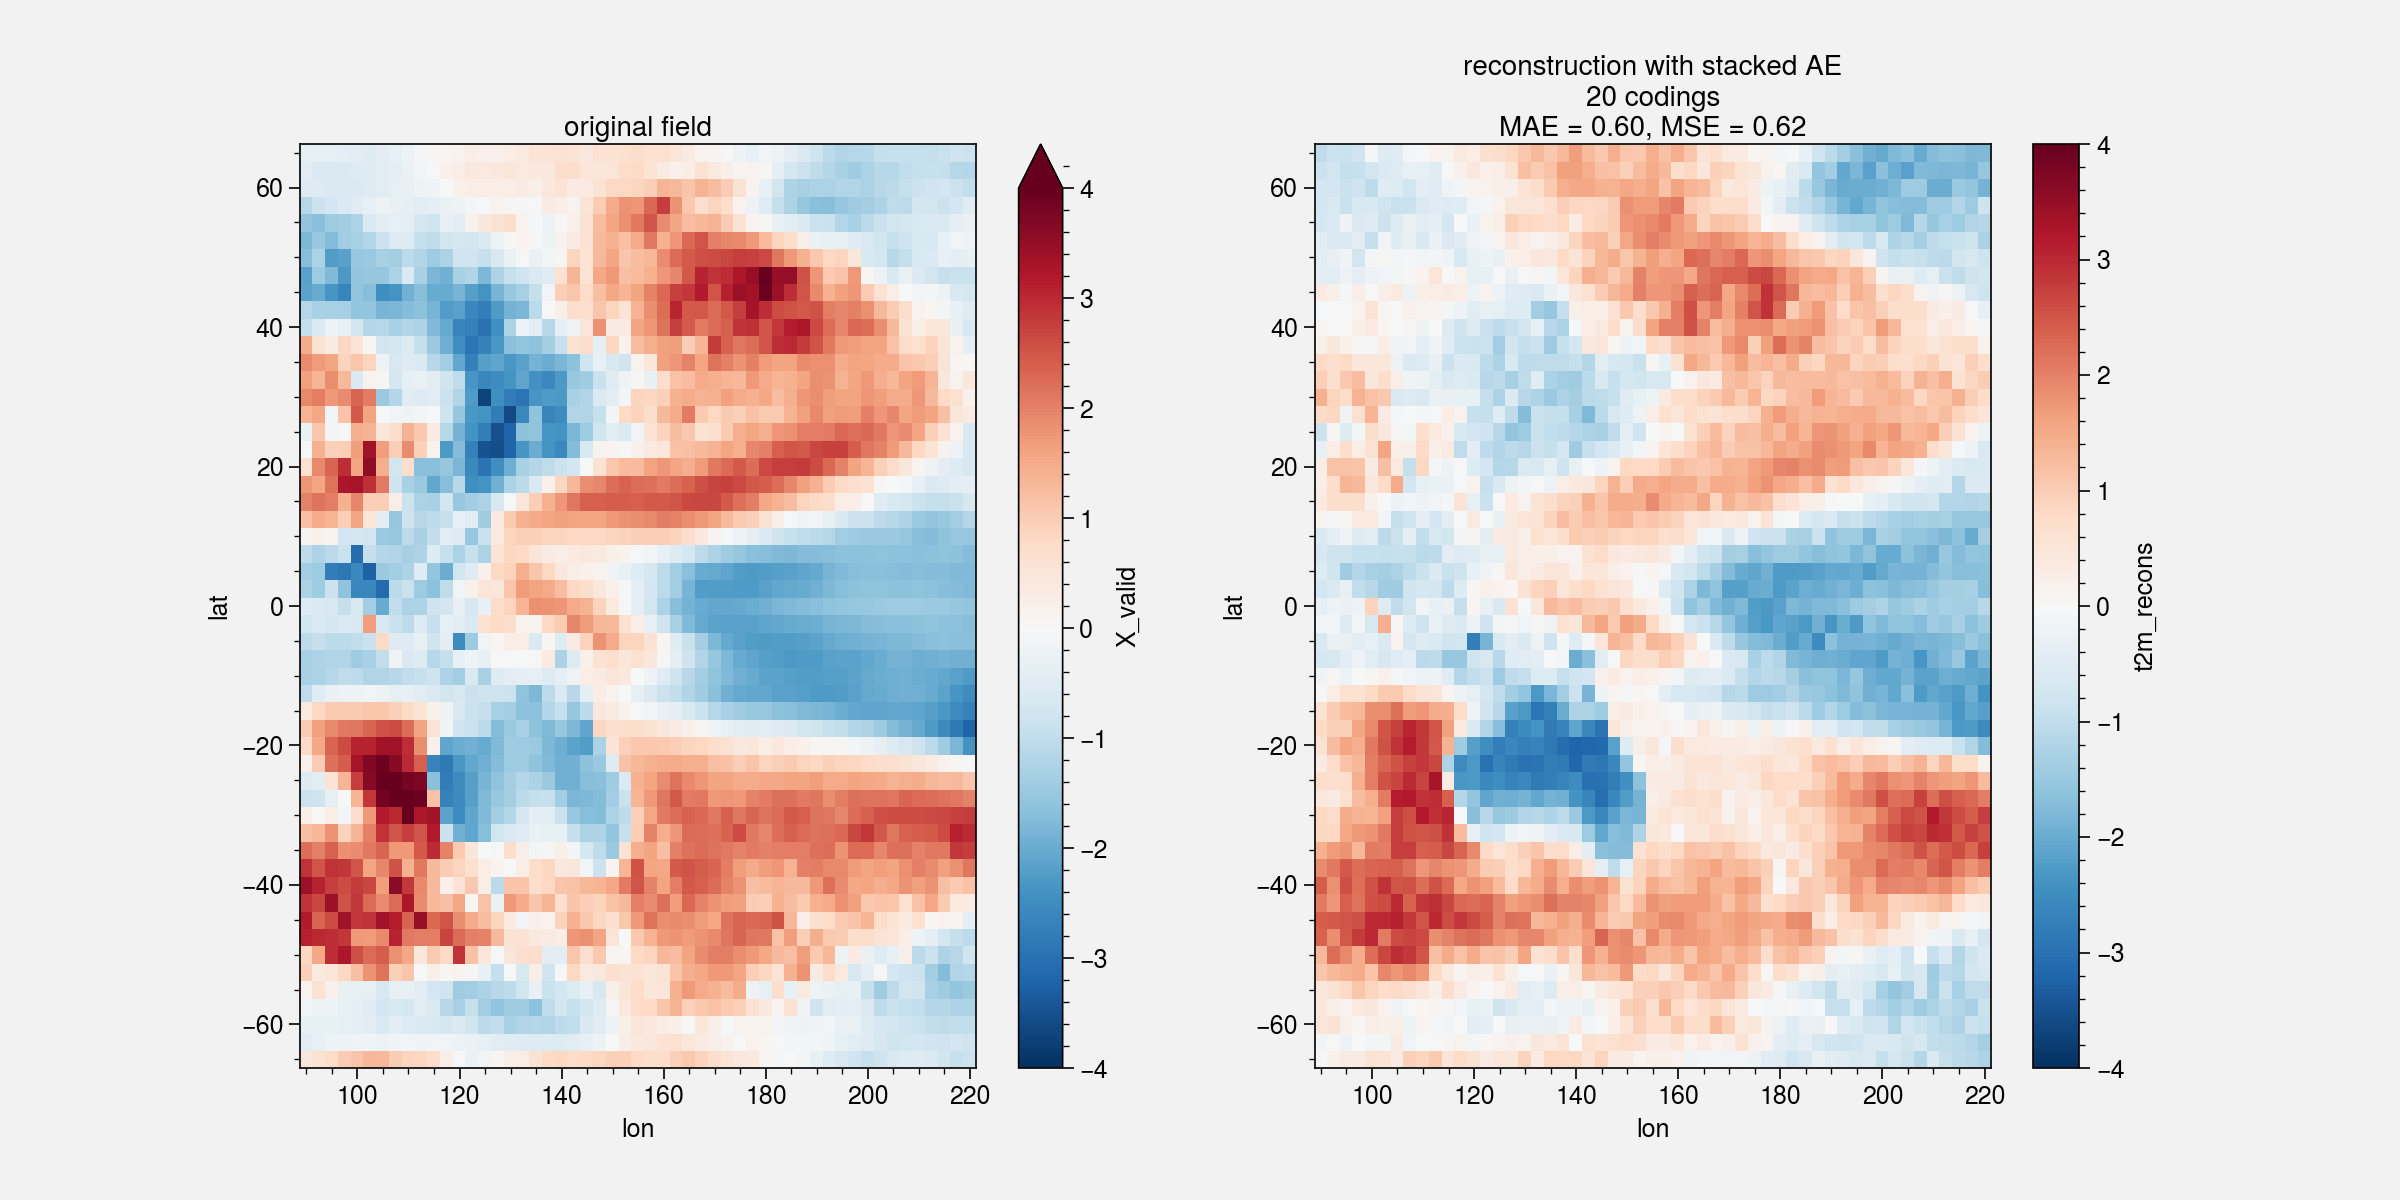

In [81]:
f, axes = plt.subplots(ncols=2, figsize=(12, 6))

dset_valid.isel(time=i)['X_valid'].plot(ax=axes[0], vmin=-4, vmax=4, cmap=plt.cm.RdBu_r)

dset_valid.isel(time=i)[var_name.lower() + '_recons'].plot(ax=axes[1], vmin=-4,  vmax=4, cmap=plt.cm.RdBu_r)

axes[0].set_title('original field')

axes[1].set_title(f'reconstruction with stacked AE\n{n_codings} codings\nMAE = {last_mae:4.2f}, MSE = {last_mse:4.2f}')

In [59]:
codings.shape

(72, 20)

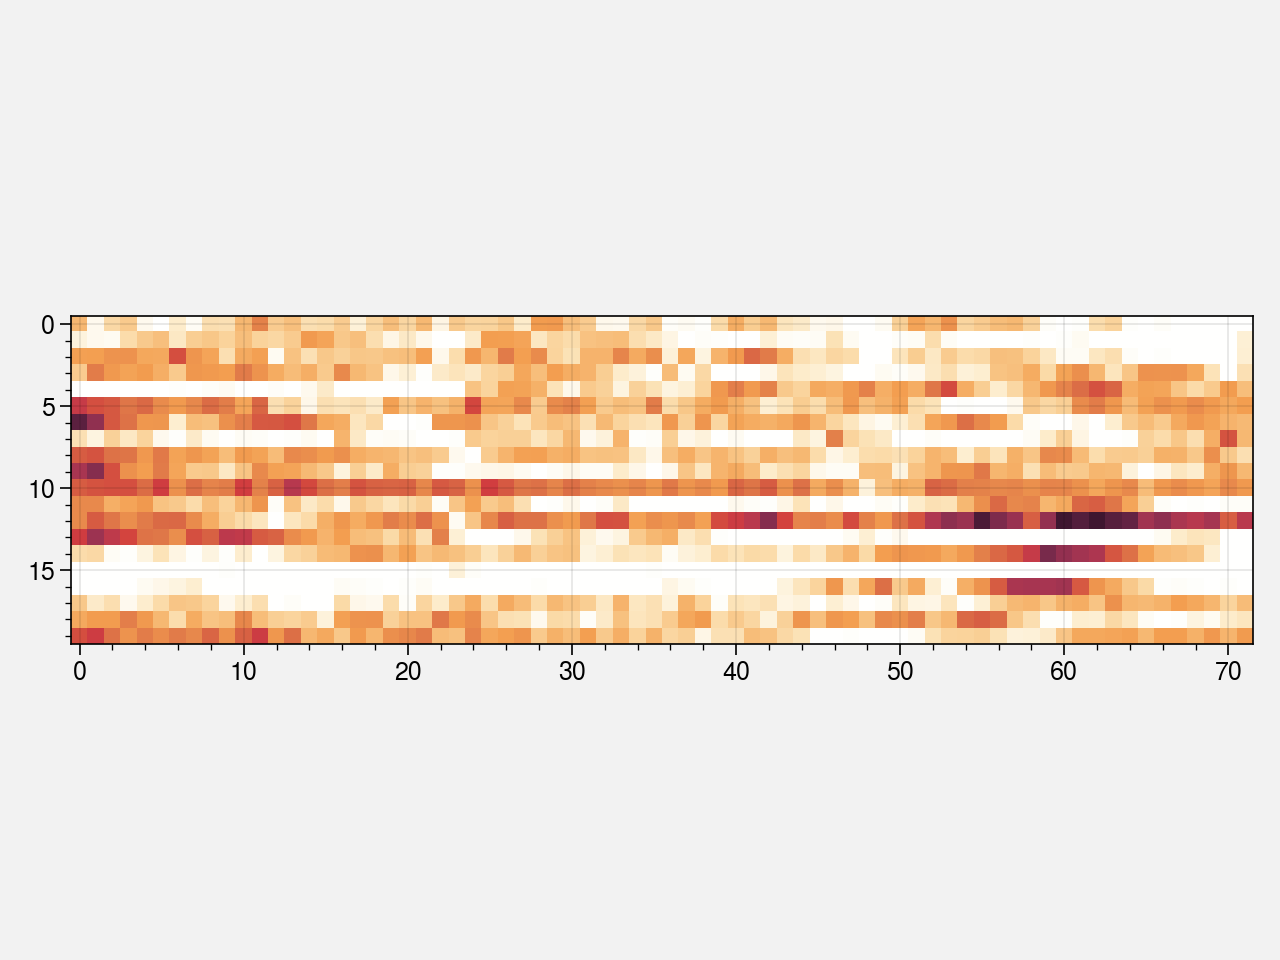

In [60]:
plt.imshow(codings.T)
plt.tight_layout()

---- 

### PCA 

In [61]:
from sklearn.decomposition import pca

In [62]:
skpca = pca.PCA()

In [63]:
skpca.fit(X_train.reshape(X_train.shape[0],X_train.shape[1] * X_train.shape[2]))

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [64]:
X_train.shape

(216, 53, 53)

In [65]:
PCs = skpca.transform(X_valid.reshape(X_valid.shape[0],X_valid.shape[1] * X_valid.shape[2]))

In [66]:
PCs.shape

(72, 216)

In [67]:
PCs = PCs[:,:n_codings]

In [68]:
EOFs = skpca.components_

In [69]:
EOFs = EOFs[:n_codings,:]

In [70]:
EOFs.shape

(20, 2809)

In [71]:
PCs.shape

(72, 20)

In [72]:
recons_pca = np.dot(PCs, EOFs)

In [73]:
recons_pca.shape

(72, 2809)

In [74]:
recons_pca = recons_pca.reshape(recons_pca.shape[0], ny, nx)

In [75]:
recons_pca.shape

(72, 53, 53)

In [76]:
dset_valid[var_name.lower() + '_recons_PCA'] = (('time','lat','lon'), recons_pca)

Text(0.5, 1.0, 'original field')

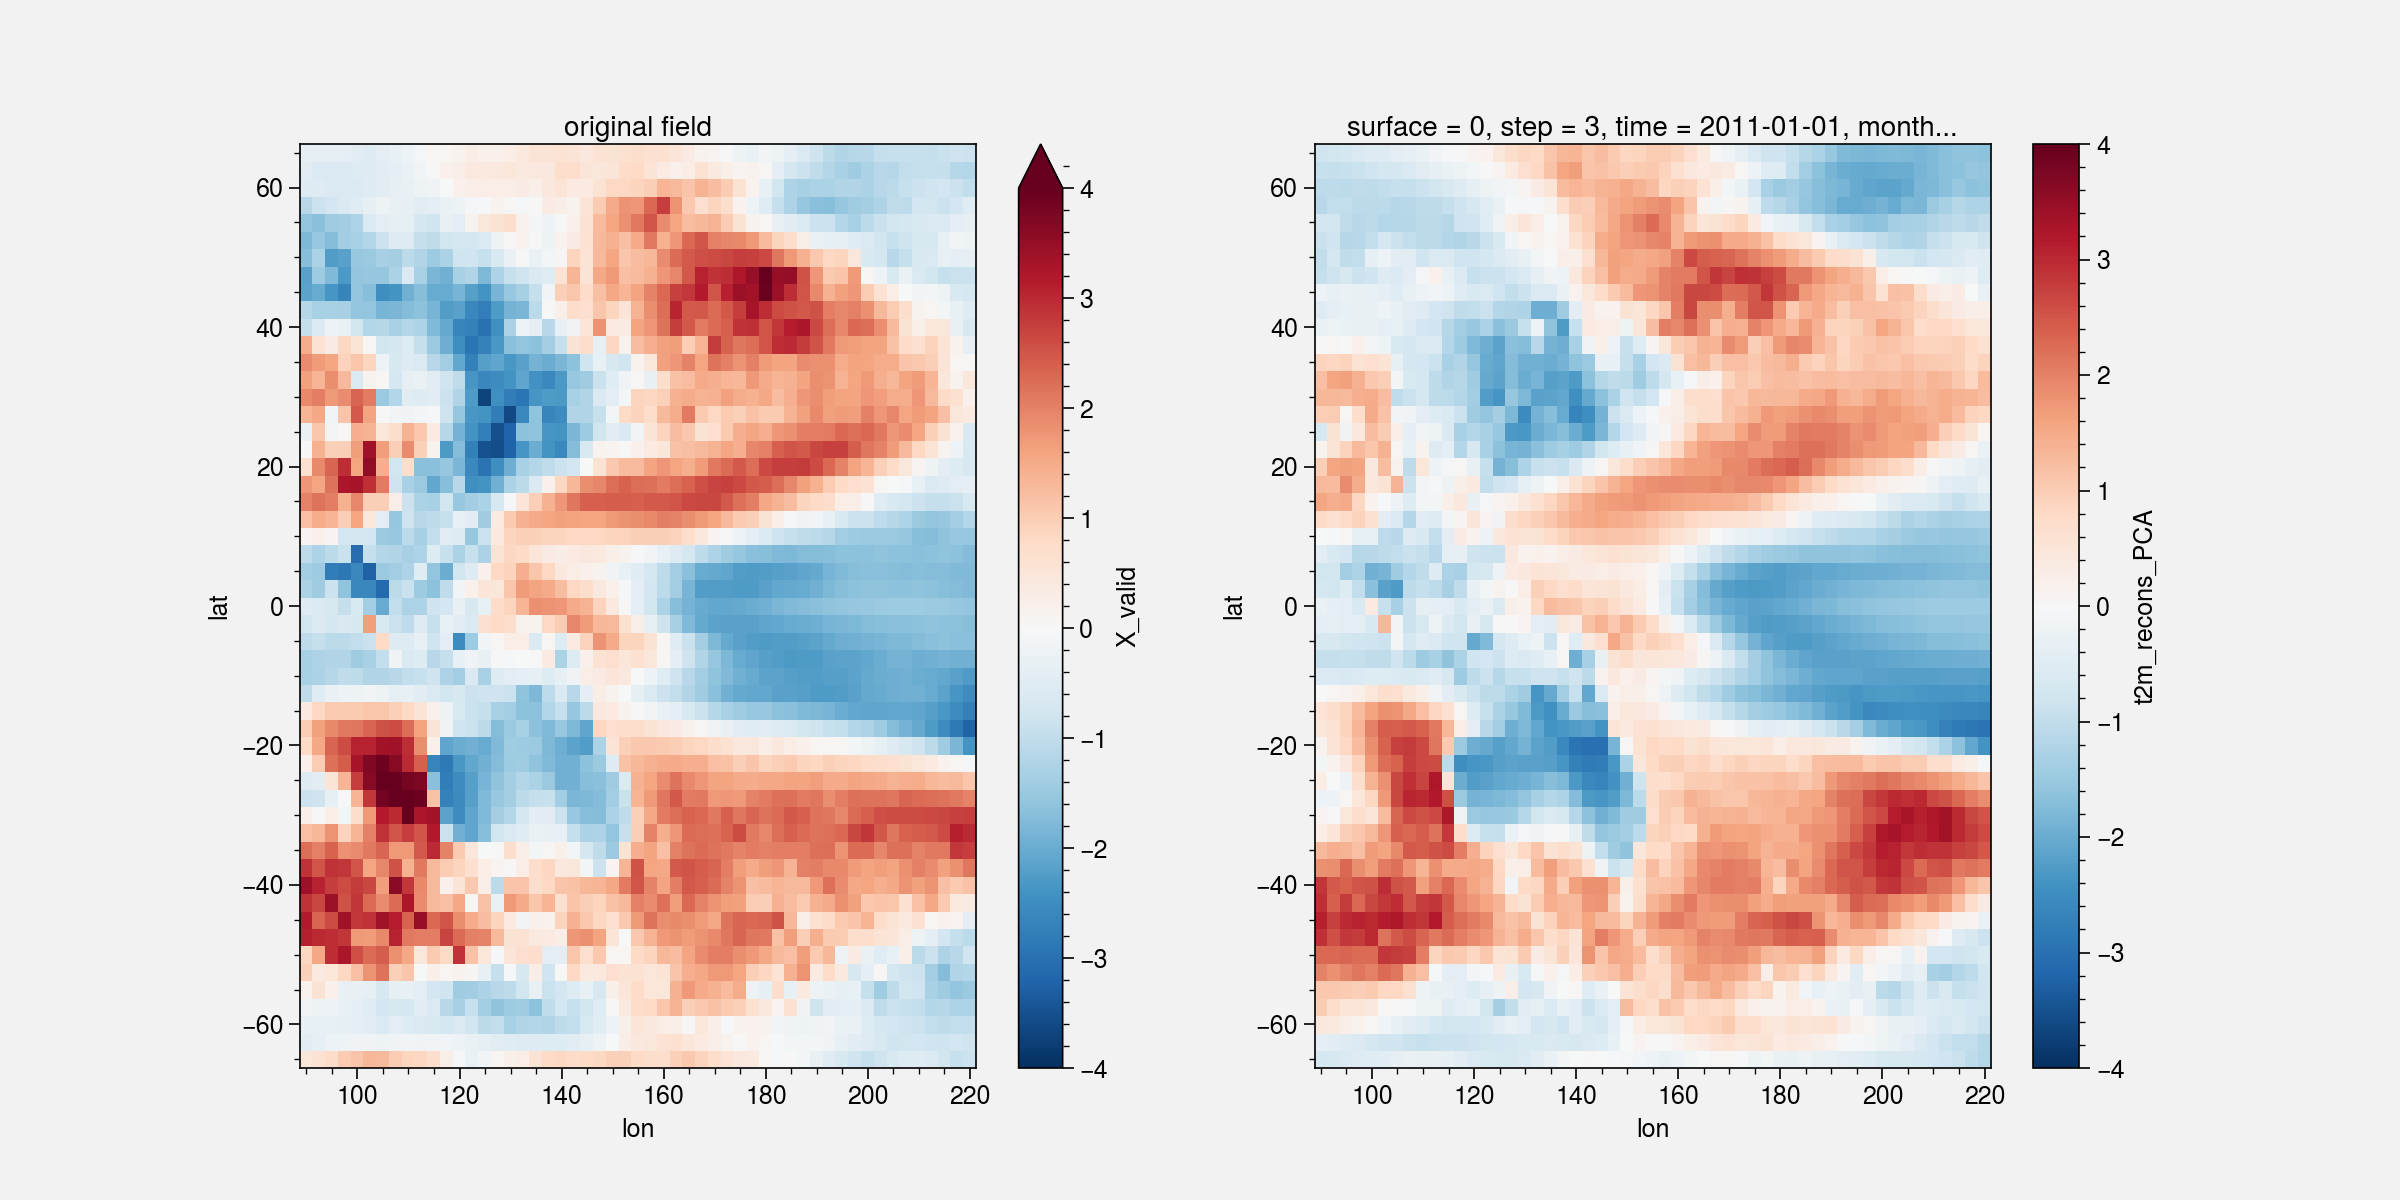

In [82]:
f, axes = plt.subplots(ncols=2, figsize=(12, 6))

dset_valid.isel(time=i)['X_valid'].plot(ax=axes[0], vmin=-4, vmax=4, cmap=plt.cm.RdBu_r)

dset_valid.isel(time=i)[var_name.lower() + '_recons_PCA'].plot(ax=axes[1], vmin=-4,  vmax=4, cmap=plt.cm.RdBu_r)

axes[0].set_title('original field')